<a href="https://colab.research.google.com/github/jbuzzio/DeepLearning/blob/main/03_arquitectura_de_linea_de_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc --no-cache -O cicids2017.zip -q https://github.com/jbuzzio/DeepLearning/raw/main/cicids2017_balanceado.zip
!unzip -n -q cicids2017.zip
!rm cicids2017.zip

In [3]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [24]:
dataset = np.load("/content/cicids2017_balanceado.npz",allow_pickle=True)
X = dataset['X']
y = dataset['y'].ravel()

In [27]:
X.shape

(5991, 60, 60, 3)

In [25]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
y_encode = lencoder.fit_transform(y)
y_encode

array([1, 1, 1, ..., 0, 0, 0])

In [4]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X,y_encode , test_size=.25)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print ("\ndistribution of train classes")
print (pd.Series(y_train).value_counts())
print ("\ndistribution of test classes")
print (pd.Series(y_test).value_counts())

(4493, 60, 60, 3) (4493,) (1498, 60, 60, 3) (1498,)

distribution of train classes
1    2264
3    1046
0     657
2     526
Name: count, dtype: int64

distribution of test classes
1    736
3    352
0    225
2    185
Name: count, dtype: int64


In [59]:
'''def modelo_convolucional(num_classes, img_size=60, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(6,6), activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model'''

In [104]:
def modelo_convolucional(num_classes, img_size=60, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(6,6), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(4,4), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [105]:
num_classes = len(np.unique(y_encode))
model = modelo_convolucional(num_classes)

using 4 classes


In [106]:
weights = model.get_weights()
for i in weights:
    print (i.shape)

(6, 6, 3, 15)
(15,)
(4, 4, 15, 60)
(60,)
(34560, 16)
(16,)
(16, 4)
(4,)


In [109]:
num_classes = len(np.unique(y_encode))

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [110]:
model = modelo_convolucional(num_classes)
model.summary()

using 4 classes


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)                 │ (None, 60, 60, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 55, 55, 15)          │           1,635 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 60)          │          14,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 34560)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         552,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_1 (Dense)                     │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 569,139 (2.17 MB)

 Trainable params: 569,139 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
train(model, batch_size=32, epochs=10, model_name="model_A")

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4836 - loss: 5.5225 - val_accuracy: 0.6542 - val_loss: 0.5736
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6387 - loss: 0.6941 - val_accuracy: 0.5915 - val_loss: 0.7050
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6555 - loss: 0.6930 - val_accuracy: 0.6896 - val_loss: 0.6503
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6774 - loss: 0.6540 - val_accuracy: 0.8278 - val_loss: 0.4187
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7038 - loss: 0.5628 - val_accuracy: 0.8465 - val_loss: 0.4302
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7348 - loss: 0.5535 - val_accuracy: 0.8451 - val_loss: 0.4053
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7830 - loss: 0.4476 - val_accuracy: 0.8505 - val_loss: 0.3326
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8605 - loss: 0.3793 - val_accuracy: 0

{'loss': 0.2623068690299988, 'compile_metrics': 0.9739652872085571}

In [112]:
test_preds = model.predict(x_test).argmax(axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [115]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Predicciones
test_preds = model.predict(x_test).argmax(axis=1)

# Etiquetas reales
true_labels = y_test  # Si y_test está en formato one-hot

print("Confusion Matrix:")
print(confusion_matrix(true_labels, test_preds))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[204  21   0   0]
 [  8 725   1   2]
 [  0   0 185   0]
 [  0   7   0 345]]


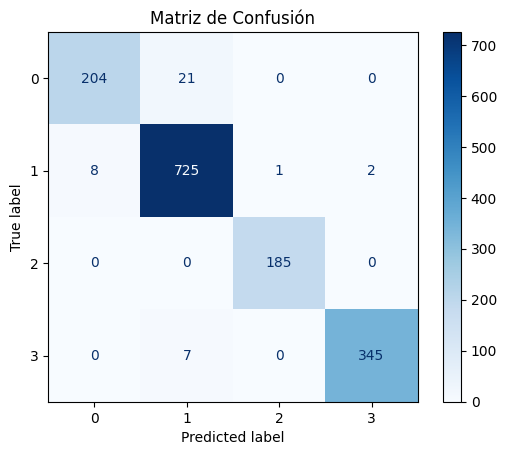

In [116]:
# Calcular la matriz de confusión
cm = confusion_matrix(true_labels, test_preds, labels=np.unique(y_encode))

# Mostrar la matriz de confusión como una gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_encode))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()